In [1]:
from pdf2image import convert_from_path
import easyocr
from paddleocr import PaddleOCR
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import math
from tqdm.auto import tqdm
from pathlib import Path

from libs.image.craft_utilities import (
    load_craft_checkpoint,
    load_craft_refiner_checkpoint,
    get_text_map,
    get_text_map_link_map_and_line_map
)

/Users/jongbeom.kim/Desktop/workspace/densecrf_test/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
def convert_to_array(img):
    img = np.array(img)
    return img


def convert_quadrilaterals_to_rectangles(df):
    df.insert(0, "ymax", df[["y1", "y2", "y3", "y4"]].max(axis=1))
    df.insert(0, "xmax", df[["x1", "x2", "x3", "x4"]].max(axis=1))
    df.insert(0, "ymin", df[["y1", "y2", "y3", "y4"]].min(axis=1))
    df.insert(0, "xmin", df[["x1", "x2", "x3", "x4"]].min(axis=1))
    df.drop(["x1", "y1", "x2", "y2", "x3", "y3", "x4", "y4"], axis=1, inplace=True)

    df[["xmin", "ymin", "xmax", "ymax"]] = df[["xmin", "ymin", "xmax", "ymax"]].astype("int")
    return df


def sharpen_image(img, iterations=1):
    kernel = np.array(
    [
        [0, -1, 0],
        [-1, 5,-1],
        [0, -1, 0]
    ]
)
    for _ in range(iterations):
        img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    return img


def get_transcript(img, map_line, ocr, reader, cuda=False):
    _, mask_line = cv2.threshold(map_line, thresh=50, maxval=255, type=cv2.THRESH_BINARY)
    n_line, _, stats, _ = cv2.connectedComponentsWithStats(
        image=mask_line, connectivity=8
    )

    ls_transcript = list()
    for idx in range(1, n_line):
        x = stats[idx, cv2.CC_STAT_LEFT]
        y = stats[idx, cv2.CC_STAT_TOP]
        width = stats[idx, cv2.CC_STAT_WIDTH]
        height = stats[idx, cv2.CC_STAT_HEIGHT]
        size = stats[idx, cv2.CC_STAT_AREA]

        niter = int(math.sqrt(size * min(width, height) / (width * height)) * 2)
        sx, ex, sy, ey = x - niter, x + width + niter + 1, y - niter, y + height + niter + 1

        patch = img[sy: ey, sx: ex, :]

        res = ocr.ocr(img=patch, det=True, rec=True, cls=False)
        # res = reader.readtext(patch)
        # print(res)

        cols = ["x1", "y1", "x2", "y2", "x3", "y3", "x4", "y4", "text", "confidence"]
        if res:
            df_result = pd.DataFrame(
                np.array([sum(i[0], []) + list(i[1]) for i in res]),
                columns=cols
            )
            # df_result = pd.DataFrame(
            #     np.array([sum(i[0], []) + [i[1], i[2]] for i in res]),
            #     columns=cols
            # )
        else:
            df_result = pd.DataFrame(columns=cols)

        df_result = convert_quadrilaterals_to_rectangles(df_result)
        df_result.sort_values(["xmin", "ymin"], inplace=True)
        
        transcript = " ".join(df_result["text"].tolist())
        
        if transcript:
            ls_transcript.append(transcript)
    df = pd.DataFrame(ls_transcript)
    return df


# def get_transcript(img, map_text, ocr, cuda=False):
#     _, mask_text = cv2.threshold(map_text, thresh=50, maxval=255, type=cv2.THRESH_BINARY)
#     n_text, _, stats, _ = cv2.connectedComponentsWithStats(
#         image=mask_text, connectivity=8
#     )

#     ls_transcript = list()
#     for idx in range(1, n_text):
#         x = stats[idx, cv2.CC_STAT_LEFT]
#         y = stats[idx, cv2.CC_STAT_TOP]
#         width = stats[idx, cv2.CC_STAT_WIDTH]
#         height = stats[idx, cv2.CC_STAT_HEIGHT]
#         size = stats[idx, cv2.CC_STAT_AREA]

#         niter = int(
#             math.sqrt(size * min(width, height) / (width * height)) * 0.8
#         )
#         sx, ex, sy, ey = x - niter, x + width + niter, y - niter, y + height + niter

#         patch = img[sy: ey, sx: ex, :]

#         res = ocr.ocr(img=patch, det=False, rec=True, cls=False)        
#         transcript = res[0][0]
        
#         if transcript:
#             ls_transcript.append(transcript)
#     df = pd.DataFrame(ls_transcript)
#     return df

In [163]:
import mmocr.utils

ModuleNotFoundError: No module named 'mmocr.utils'

In [162]:
mmocr.utils

AttributeError: module 'mmocr' has no attribute 'utils'

In [159]:
from mmocr.utils.ocr import MMOCR

# Load models into memory
ocr = MMOCR()

# # Inference
# results = ocr.readtext('demo/demo_text_ocr.jpg', print_result=True, imshow=True)

ModuleNotFoundError: No module named 'mmocr.utils'

In [94]:
text_detector = load_craft_checkpoint(cuda=False)
refiner = load_craft_refiner_checkpoint(cuda=False)
# ocr = PaddleOCR(lang="korean")
# reader = easyocr.Reader(["ko"])

# ls_img = convert_from_path("/Users/jongbeom.kim/Downloads/scanned.pdf")

Loaded pre-trained weights for 'CRAFT' from checkpoint '/Users/jongbeom.kim/Desktop/workspace/data_mgmt/apps/libs/image/pretrained/craft.pth'.
    Loaded pre-trained weights for 'CRAFT' refiner from checkpoint '/Users/jongbeom.kim/Desktop/workspace/data_mgmt/apps/libs/image/pretrained/craft_refiner.pth'.


In [97]:
map_text, map_link, map_line = get_text_map_link_map_and_line_map(
    img, text_detector=text_detector, refiner=refiner
)

In [151]:
_, mask_text = cv2.threshold(map_text, thresh=70, maxval=255, type=cv2.THRESH_BINARY)
# _, mask_link = cv2.threshold(map_link, thresh=70, maxval=255, type=cv2.THRESH_BINARY)
# mask = mask_text + mask_link

In [154]:
n_line, _, stats, _ = cv2.connectedComponentsWithStats(
    image=mask_text, connectivity=8
)

ocr_ko = PaddleOCR(lang="korean")
ocr_ja = PaddleOCR(lang="japan")
# ls_transcript = list()
for idx in range(1, 50):
    # idx = 22
    x = stats[idx, cv2.CC_STAT_LEFT]
    y = stats[idx, cv2.CC_STAT_TOP]
    width = stats[idx, cv2.CC_STAT_WIDTH]
    height = stats[idx, cv2.CC_STAT_HEIGHT]
    size = stats[idx, cv2.CC_STAT_AREA]

    niter = int(math.sqrt(size * min(width, height) / (width * height)))
    sx, ex, sy, ey = x - niter, x + width + niter, y - niter, y + height + niter

    patch = img[sy: ey, sx: ex, :]

    # print(reader.readtext(image=patch, detail=0))
    print(ocr_ko.ocr(img=patch, det=False, rec=True, cls=False)[0][0])
    print(ocr_ja.ocr(img=patch, det=False, rec=True, cls=False)[0][0])
    # ocr = PaddleOCR(lang="japan")

피고인
正四ビ!
신문의
山品9
예
0
||
ıı

口
다음은
山台
절도죄로
智エ呈
벌금명령을
増書出引
받고
ごユ
정식재판을
忍斗
청구한
礼子斗
중국국적
そエエコ
양조우
よ
피고인
羽ユ
신문이다
Aoit4.4
에
1
대한
山斗
판사의
弘ト四
양조우가
よ堅イ外
일하던
9
가게의
フ日
업주는
ヨイと
양조우를
よ畳
절도죄로
智豆里
고
ユ
소했고
全ユ,
이에
0101
대해
山
피고인은
羽ユ91:
월급의
言01
일부를
9早畳
매출액에서
山善u内
가져간
フロ北
것이라
斗
주장하고
千イユ
있다
刻は.
재판장'
利む:
양조우씨
よ千幻
절도죄로
智三呈
벌금
聖書
50만
;0弘
원
:
약식명령
9沿中
정식재판
忍刻斗
받고
ごユ
청구했죠
コ千αえ
피고인
H9:
예
ă.
재판장'
大む:


(-0.5, 1433.5, 2026.5, -0.5)

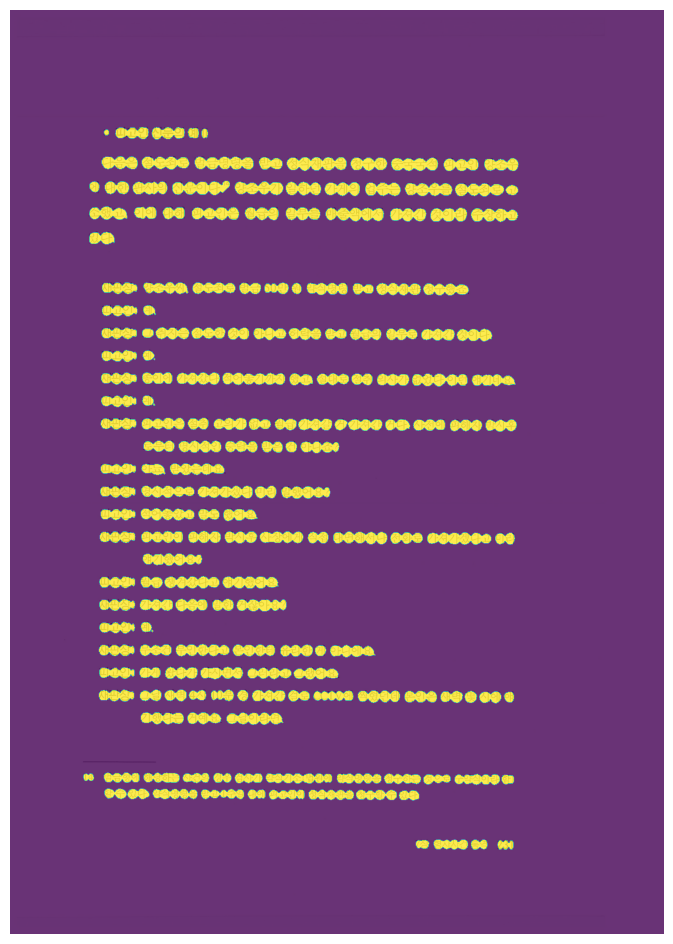

In [150]:
plt.figure(figsize=(12, 12))
plt.imshow(mask_text)
plt.imshow(img, alpha=0.2)
plt.axis("off")

In [132]:
ocr = PaddleOCR(lang="korean")
# ocr = PaddleOCR(lang="japan")
res = ocr.ocr(img=patch, det=False, rec=True, cls=False)
res

[('소했고', 0.9999236464500427)]

In [133]:
reader = easyocr.Reader(["ko"])
reader.readtext(image=patch, detail=0)

WARNING 2022-11-29 12:03:39,824 easyocr.py:74] CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['소햇고,']

In [ ]:
# reader = easyocr.Reader(["ko", "en"])
reader.readtext(image=patch, decoder="beamsearch", beamWidth=20, detail=0, paragraph=True)

In [4]:
idx = 0

img = ls_img[idx]
img = convert_to_array(img)

map_line = cv2.imread(
    f"/Users/jongbeom.kim/Documents/ocr/map_line/{idx}.png", cv2.IMREAD_GRAYSCALE
)

In [9]:
_, mask_line = cv2.threshold(map_line, thresh=50, maxval=255, type=cv2.THRESH_BINARY)
n_line, _, stats, _ = cv2.connectedComponentsWithStats(
    image=mask_line, connectivity=8
)

# ls_transcript = list()
# for idx in range(1, n_line):
idx = 10
x = stats[idx, cv2.CC_STAT_LEFT]
y = stats[idx, cv2.CC_STAT_TOP]
width = stats[idx, cv2.CC_STAT_WIDTH]
height = stats[idx, cv2.CC_STAT_HEIGHT]
size = stats[idx, cv2.CC_STAT_AREA]

niter = int(math.sqrt(size * min(width, height) / (width * height)) * 2)
sx, ex, sy, ey = x - niter, x + width + niter + 1, y - niter, y + height + niter + 1

patch = img[sy: ey, sx: ex, :]

In [205]:
for idx in tqdm(range(len(ls_img))):
    path = Path(f"/Users/jongbeom.kim/Documents/ocr/result/{str(idx).zfill(3)}.xlsx")
    if not path.exists():
        img = ls_img[idx]
        img = convert_to_array(img)
        
        map_line = cv2.imread(
            f"/Users/jongbeom.kim/Documents/ocr/map_line/{idx}.png", cv2.IMREAD_GRAYSCALE
        )
        
        df = get_transcript(img=img, map_line=map_line, ocr=ocr, reader=reader, cuda=False)
        
        # display(df)
        df.to_excel(path, index=False)

 29%|██▉       | 33/112 [11:53<28:27, 21.61s/it]


KeyboardInterrupt: 

In [206]:
for i, page in enumerate(ls_img):
	page.save(f"/Users/jongbeom.kim/Documents/ocr/image/{str(i).zfill(3)}.jpg", "JPEG")

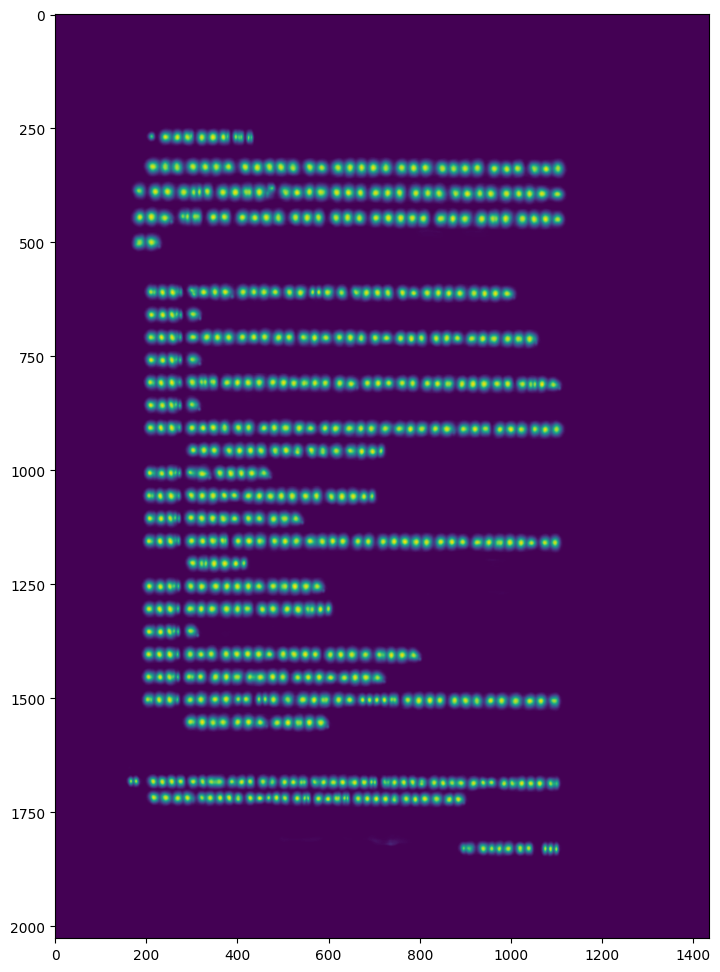

In [208]:
plt.figure(figsize=(12, 12))
plt.imshow(map_text)
# plt.imshow(img, alpha=0.2)